In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
!gdown --id 1NGlXT9sIaQpyxUoT6MLKm1Pr6x8oxOvc


Downloading...
From: https://drive.google.com/uc?id=1NGlXT9sIaQpyxUoT6MLKm1Pr6x8oxOvc
To: /content/NEU-CLS.rar
50.7MB [00:01, 49.7MB/s]


In [2]:
!pip install patool

     |████████████████████████████████| 81kB 8.4MB/s 


In [3]:
import patoolib
import os
import shutil
#os.mkdir("NEU-CLS")
#shutil.rmtree("NEU-CLS")
patoolib.extract_archive("NEU-CLS.rar", outdir="./")

patool: Extracting NEU-CLS.rar ...
patool: running /usr/bin/unrar x -- /content/NEU-CLS.rar
patool:     with cwd='./'
patool: ... NEU-CLS.rar extracted to `./'.


'./'

4


/content/fourier_mellin.py:162: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = np.log(np.abs(imgOriginalLogPolarComplex))


0.6194444444444446
tensor(0.0896, device='cuda:0', grad_fn=<MseLossBackward>)
0.713888888888889
tensor(0.0735, device='cuda:0', grad_fn=<MseLossBackward>)
0.7666666666666667
tensor(0.0618, device='cuda:0', grad_fn=<MseLossBackward>)
0.8083333333333333
tensor(0.0572, device='cuda:0', grad_fn=<MseLossBackward>)
0.7944444444444444
tensor(0.0445, device='cuda:0', grad_fn=<MseLossBackward>)
0.8444444444444446
tensor(0.0468, device='cuda:0', grad_fn=<MseLossBackward>)
0.85
tensor(0.0396, device='cuda:0', grad_fn=<MseLossBackward>)
0.8944444444444444
tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward>)
0.9138888888888891
tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward>)
0.9027777777777776
tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward>)
0.8916666666666667
tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward>)
0.9277777777777778
tensor(0.0211, device='cuda:0', grad_fn=<MseLossBackward>)
0.9222222222222224
tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward>)
0

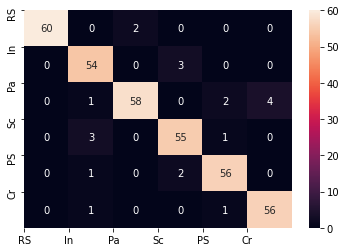

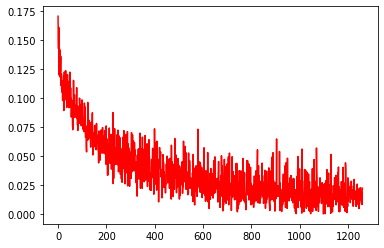

'\nnet = Net3(layer1=220,layer2=100,layer3=30,ksize=15)\nnet.to(device)\ncriterion = nn.MSELoss()\noptimizer = optim.Adam(net.parameters())\n\nlosses = train(net,optimizer,criterion,batchsched=[5,10],epoch_sched = [5,5])\n\nplt.plot(losses,\'b-\')\nplt.legend(["layer1=220,layer2=100,layer3=60,ksize=15","layer1=220,layer2=100,layer3=30,ksize=15"])\nplt.savefig("2vs3.png")\nplt.show()\n'

In [5]:
import torch
from torch import nn
from torch import optim
import glob
import os
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import seaborn

from fourier_mellin import mellin_fourier

np.random.seed(123)
torch.manual_seed(123)

device = torch.device("cuda:0")

class_names = ["RS","In","Pa","Sc","PS","Cr"]

def transform1(im):
    #im = cv2.resize(im,(25,25))
    trans = mellin_fourier(im)
    #trans = cv2.resize(trans,(20,20))
    return trans

def fourier_magnitude(im):
    fft = np.fft.fft2(im)
    mag = np.log(np.abs(fft))
    return mag

def make_fname(dir,type,num):
    fn = "%s_%d.bmp"%(type,num)
    return os.path.join(dir,fn)


def get_names(dir="./NEU-CLS"):
    names = {}
    randarray = np.arange(1,301)
    for c in class_names:
        np.random.shuffle(randarray)
        names[c] = np.array([make_fname(dir,c,i) for i in randarray])
    return names

class BatchLoader:
    def __init__(self,names,batchsize=4):
        self.names = names
        self.count = 0
        self.batchsize = batchsize

    def __iter__(self):
        return self

    def __next__(self):
        if self.count > int(len(self.names['PS']) - self.batchsize):
            raise StopIteration
        pack = []
        labels = []
        for c in class_names:
            pack.append(self.names[c][self.count:(self.count + self.batchsize)])
            hotvecs = np.zeros((self.batchsize,6))
            hotvecs[:,class_names.index(c)] = 1
            labels.append(hotvecs)
        fns = np.concatenate(tuple(pack))
        labels = torch.tensor(np.concatenate(tuple(labels)),dtype=torch.float32)
        #tensor = torch.tensor(np.array([[fourier_magnitude(plt.imread(f))] for f in fns]),dtype=torch.float32)
        #tensor = torch.tensor(np.array([[plt.imread(f)] for f in fns]),dtype=torch.float32)
        tensor = torch.tensor(np.array([[transform1(plt.imread(f))] for f in fns]),dtype=torch.float32)
        tensor = tensor/torch.tensor(255)
        self.count+=self.batchsize
        return tensor,labels
    def reset(self):
      self.counter = 0

class SteelBatchLoader:
    def __init__(self,dir="./NEU-CLS",test_split = 0.8,batchsize=4):
        self.batchsize = batchsize
        names = get_names(dir)
        ind = int(0.8*300)
        self.trainnames = {}
        self.testnames = {}
        for c in names:
            self.trainnames[c] = names[c][:ind]
            self.testnames[c] = names[c][ind:]
        self.train = BatchLoader(self.trainnames,batchsize=self.batchsize)
        self.test = BatchLoader(self.testnames,batchsize=self.batchsize)

    def reset(self):
        #for c in class_names:
        #    np.random.shuffle(self.trainnames[c])
        self.train = BatchLoader(self.trainnames,batchsize=self.batchsize)
        self.test = BatchLoader(self.testnames,batchsize=self.batchsize)

def evaluate(testloader):
    batches = []
    for data,labels in testloader:
        data = data.to(device)
        out = net(data)
        out = out.cpu().detach().numpy()
        labels = labels.detach().numpy()
        right = (np.argmax(out,axis=1)) == (np.argmax(labels,axis=1)) 
        batches.append( np.sum(right)/len(right))
    return np.mean(batches)

def plot_confusion(testloader):
    batches = []
    conf = np.zeros((len(class_names),len(class_names)))
    for data,labels in testloader:
        data = data.to(device)
        out = net(data)
        out = out.cpu().detach().numpy()
        labels = labels.detach().numpy()
        guess = (np.argmax(out,axis=1)) 
        right = (np.argmax(labels,axis=1))
        for i,j in zip(guess,right):
            conf[i][j]+=1 
        
    #plt.imshow(conf)
    seaborn.heatmap(conf,annot=True)
    plt.yticks(np.arange(len(class_names)),tuple(class_names))
    plt.xticks(np.arange(len(class_names)),tuple(class_names))
    plt.show()


class Net(nn.Module):
    def __init__(self,layer1 = 120,layer2 = 60):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, layer1, kernel_size=10)
        self.drop = nn.Dropout(0.2)
        self.maxpool1 = nn.MaxPool2d(5,5)
        self.maxpool2 = nn.MaxPool2d(2,2)
        self.norm1 = nn.BatchNorm2d(layer1)
        self.norm2 = nn.BatchNorm2d(layer2)
        self.norm3 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(layer1, layer2, kernel_size=1)
        self.conv3 = nn.Conv2d(layer2, 6, kernel_size=1)
        self.softmax = nn.Softmax(dim =1)
        self.maxpool = nn.AdaptiveMaxPool2d((1,1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.drop(x)
        x = self.norm1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.drop(x)
        x = self.norm2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = self.drop(x)
        x = self.norm3(x)
        x = self.maxpool(x)
        x = x.view(-1,6)
        x = self.softmax(x)
        return x

def make_FC_layer(channels_in,channels_out,ksize=5,dropout = 0,maxpool=None):
    ops = [nn.Conv2d(channels_in,channels_out,kernel_size=ksize)]
    if maxpool:
        ops.append(nn.MaxPool2d(*maxpool))
    if dropout:
        ops.append(nn.Dropout(dropout))
    ops.append(nn.BatchNorm2d(channels_out))
    return nn.Sequential(*tuple(ops))

class Net2(nn.Module):
    def __init__(self,layer1 = 120,layer2 = 60,ksize =20):
        super(Net2, self).__init__()
        self.l1 = make_FC_layer(1,layer1,ksize=ksize,dropout=0.2,maxpool=(5,5))
        self.l2 = make_FC_layer(layer1,layer2,ksize=1,dropout=0.2,maxpool=(2,2))
        self.output = make_FC_layer(layer2,6,ksize=1,dropout=0.2)
        self.softmax = nn.Softmax(dim =1)
        self.maxpool = nn.AdaptiveMaxPool2d((1,1))

    def forward(self, x):
        x = self.l1(x)
        x = torch.relu(x)
        x = self.l2(x)
        x = torch.relu(x)
        x = self.output(x)
        x = self.maxpool(x)
        x = x.view(-1,6)
        x = self.softmax(x)
        return x

class Net3(nn.Module):
    def __init__(self,layer1 = 220,layer2 = 100,layer3 = 60,ksize=15):
        super(Net3, self).__init__()
        self.l1 = make_FC_layer(1,layer1,ksize=ksize,dropout=0.2,maxpool=(8,8))
        self.l2 = make_FC_layer(layer1,layer2,ksize=1,dropout=0.2)
        self.l3 = make_FC_layer(layer2,layer3,ksize=1,dropout=0.2)
        self.output = make_FC_layer(layer3,6,ksize=1,dropout=0.2)
        self.softmax = nn.Softmax(dim =1)
        self.maxpool = nn.AdaptiveMaxPool2d((1,1))

    def forward(self, x):
        x = self.l1(x)
        x = torch.relu(x)
        x = self.l2(x)
        x = torch.relu(x)
        x = self.l3(x)
        x = torch.relu(x)
        x = self.output(x)
        x = self.maxpool(x)
        x = x.view(-1,6)
        x = self.softmax(x)
        return x

class Net4(nn.Module):
    def __init__(self,layer1 = 120,layer2 = 60,ksize =20):
        super(Net4, self).__init__()
        self.l1 = make_FC_layer(1,layer1,ksize=ksize,dropout=0.2)
        self.l2 = make_FC_layer(layer1,layer2,ksize=5,dropout=0.2)
        self.output = make_FC_layer(layer2,6,ksize=5,dropout=0.2)
        self.softmax = nn.Softmax(dim =1)
        self.maxpool = nn.AdaptiveMaxPool2d((1,1))

    def forward(self, x):
        x = self.l1(x)
        x = torch.relu(x)
        x = self.l2(x)
        x = torch.relu(x)
        x = self.output(x)
        x = self.maxpool(x)
        x = x.view(-1,6)
        x = self.softmax(x)
        return x

class Net5(nn.Module):
    def __init__(self,layer1 = 16,layer2 = 12,ksize=5):
        super(Net5, self).__init__()
        self.mp1 = nn.MaxPool2d(10,10)
        self.l1 = make_FC_layer(1,layer1,ksize=ksize,dropout=0.2)
        self.l2 = make_FC_layer(layer1,layer2,ksize=3,dropout=0.2)
        self.output = make_FC_layer(layer2,6,ksize=3,dropout=0.2)
        self.softmax = nn.Softmax(dim =1)
        self.maxpool = nn.AdaptiveMaxPool2d((1,1))

    def forward(self, x):
        x = self.mp1(x)
        x = self.l1(x)
        x = torch.relu(x)
        x = self.l2(x)
        x = torch.relu(x)
        x = self.output(x)
        x = self.maxpool(x)
        x = x.view(-1,6)
        x = self.softmax(x)
        return x




def train(net,optimizer,criterion,batchsched=[10],epoch_sched=[20]):
    losses = []
    loss = None
    for n_epochs,batchsize in zip(epoch_sched,batchsched):
        loader = SteelBatchLoader(batchsize=batchsize)
        print(batchsize)
        for epoch in range(n_epochs):
            for data,labels in loader.train:
                #data = data*0.9 + torch.rand(data.shape)*0.1
                data = data.to(device)

                labels = labels.to(device)
                out = net(data)
                loss = criterion(out,labels)
        
                loss.backward()
                optimizer.step()
                losses.append(float(loss.detach()))
            print(evaluate(loader.test))
            loader.reset()
            print(loss)
    plot_confusion(loader.test)
    return losses

loader = SteelBatchLoader(batchsize=4)

net = Net2(layer1=220,layer2=100,ksize=20) #the good one
#net = Net4(layer1=220,layer2=100,ksize=25)
#net = Net5(layer1=20,layer2=10,layer3=10,ksize=5)
#net = Net5(layer1=50,layer2=20,ksize=5) # good one 2
net = Net5(layer1=16,layer2=12,ksize=10)
net = Net5(layer1=25,layer2=12,ksize=10)
#net = LinNet()
net.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

#losses = train(net,optimizer,criterion,batchsched=[4,20,35],epoch_sched = [20,20,20])
losses = train(net,optimizer,criterion,batchsched=[4,20],epoch_sched = [20,5])

plt.plot(losses,'r-')
plt.savefig("220_100_25_lowmax.png")
plt.show()
torch.save(net.state_dict(),"Steel_FCN")
'''
net = Net3(layer1=220,layer2=100,layer3=30,ksize=15)
net.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

losses = train(net,optimizer,criterion,batchsched=[5,10],epoch_sched = [5,5])

plt.plot(losses,'b-')
plt.legend(["layer1=220,layer2=100,layer3=60,ksize=15","layer1=220,layer2=100,layer3=30,ksize=15"])
plt.savefig("2vs3.png")
plt.show()
'''



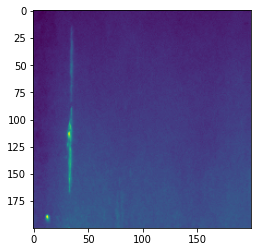

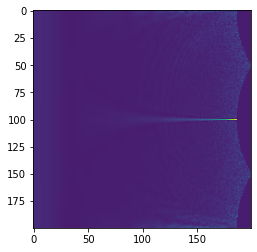

In [11]:
import seaborn

im = plt.imread("./NEU-CLS/Sc_1.bmp")

imt = transform1(im)

plt.imshow(im)
plt.show()
plt.imshow(imt)


def plot_confusion2(testloader):
    batches = []
    conf = np.zeros((len(class_names),len(class_names)))
    for data,labels in testloader:
        data = data.to(device)
        out = net(data)
        out = out.cpu().detach().numpy()
        labels = labels.detach().numpy()
        guess = (np.argmax(out,axis=1)) 
        right = (np.argmax(labels,axis=1))
        for i,j in zip(guess,right):
            conf[i][j]+=1 
        
    seaborn.heatmap(conf,annot=True)
    plt.yticks(np.arange(len(class_names)),tuple(class_names))
    plt.xticks(np.arange(len(class_names)),tuple(class_names))
    plt.show()

  # plot_confusion2()